## scikit-image for 3D image analysis
- 2022 skimage data umbrella workshop

*Import libraries*

In [120]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import supplementary_code as sc

%matplotlib inline 
# Monospace font for figrures

plt.rcParams['font.family'] = 'monospace'

### skimage.io - Utilities to read/write images

- io.imread: read an image to a numpy array.
- io.imsave: write an image to disk.
- io.imread_collection: read multiple images which match a common pattern.


In [121]:
from skimage import io 
cells = io.imread('data/cells.tif')

In [122]:
print(f'cells shape: {cells.shape}')
print(f'cells type: {cells.dtype}')
print(f'cells range: {cells.min()}, {cells.max()}')

cells shape: (60, 256, 256)
cells type: float64
cells range: 0.0, 1.0


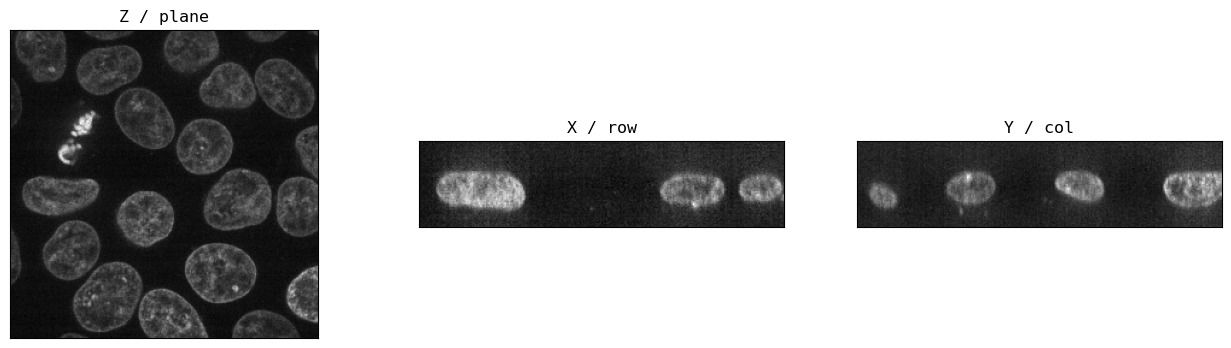

In [123]:
# Fix one axis, then observe three different views of img

_, (win_left, win_center, win_right) = plt.subplots(nrows=1, ncols=3, figsize = (16, 4))
sc.show_plane(win_left, cells[32], title = 'Z / plane')
sc.show_plane(win_center, cells[:, 128, :], title = 'X / row')
sc.show_plane(win_right, cells[:,:, 128], title = 'Y / col')

In [124]:
# interactive 2D slicer
sc.slice_explorer(cells)

interactive(children=(IntSlider(value=30, description='plane', max=59), Output()), _dom_classes=('widget-inter…

<function supplementary_code.slice_explorer.<locals>.display_slice(plane=30.0)>

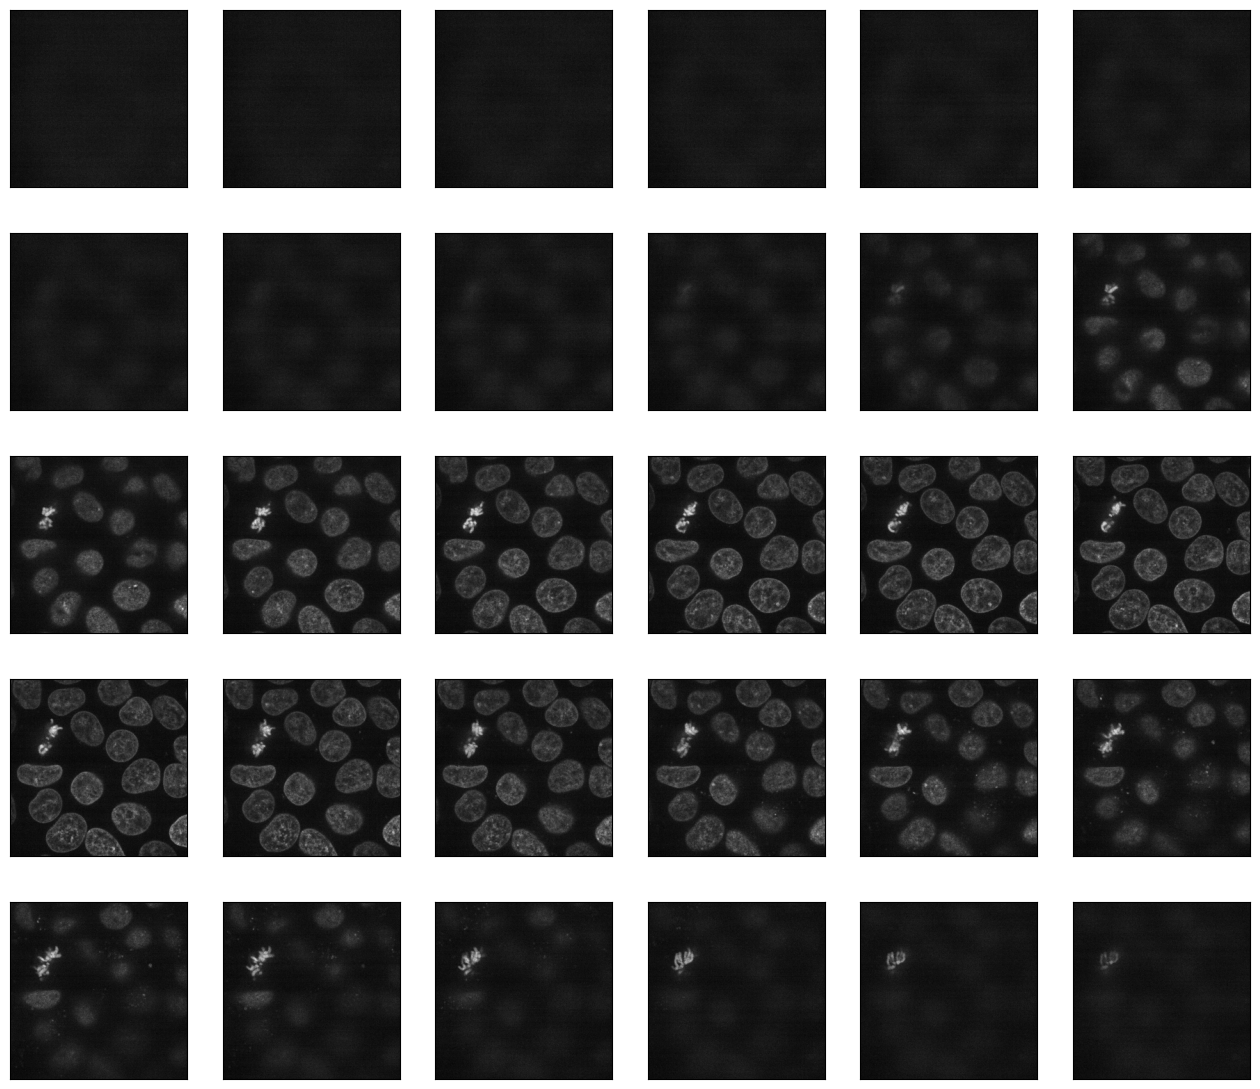

In [125]:
# Display snaps of all planes or Z slices
sc.display(cells)

### skimage.exposire - evaluating / changing the exposure of an image
- Module with multiple functions to change img contrast

In [126]:
from skimage import exposure

In [127]:
# Remove 0.5% of the darkest and brightest pixels to increase overall contrast of image
vmin, vmax = np.percentile(cells, q= (0.5, 99.5))
cells_rescaled = exposure.rescale_intensity(
    cells,
    in_range=(vmin, vmax),
    out_range=np.float32
)

sc.slice_explorer(cells_rescaled)

interactive(children=(IntSlider(value=30, description='plane', max=59), Output()), _dom_classes=('widget-inter…

<function supplementary_code.slice_explorer.<locals>.display_slice(plane=30.0)>

## Edge detection

- highlight regions in image where a sharp change in contrast happens
- intensity of an edge corresponds to the steepness of the transition of one intensity to another
- eg. 
    - dim edge: gradual shifft from bright to dark intensity
    - bright edge: abrupt shift 


### skimage.filters 

Testing with sobel filter # note sobel needs to be applied plane wise in 2d, no 3d:

In [128]:
from skimage import filters

cell_sobel = np.empty_like(cells_rescaled)

for z_plane, image in enumerate(cells_rescaled):
    cell_sobel[z_plane] = filters.sobel(image)

sc.slice_explorer(cell_sobel)

interactive(children=(IntSlider(value=30, description='plane', max=59), Output()), _dom_classes=('widget-inter…

<function supplementary_code.slice_explorer.<locals>.display_slice(plane=30.0)>

### skimage.transform

- Reconstructing medical CT images use:
    - Radon (forward)
    - iradon (reverse)
    - iradon_sart
    - finite versions of above transforms, frt2 and ifrt2

- Identify lines, circles and ellipes:
    - Hough transforms

- Change image size, shape or resolution:
    - resize
    - rescale
    - downsample_local_mean

- Translate coordinates or image
    - warp_coordinates
    - warp
    - estimate_transform- parameter estimation

- Note panorama tutorial warping -Similarity transform with paramaeter estimation via measre.ransac

Text(0.5, 1.0, 'Downsampled: (2, 2)')

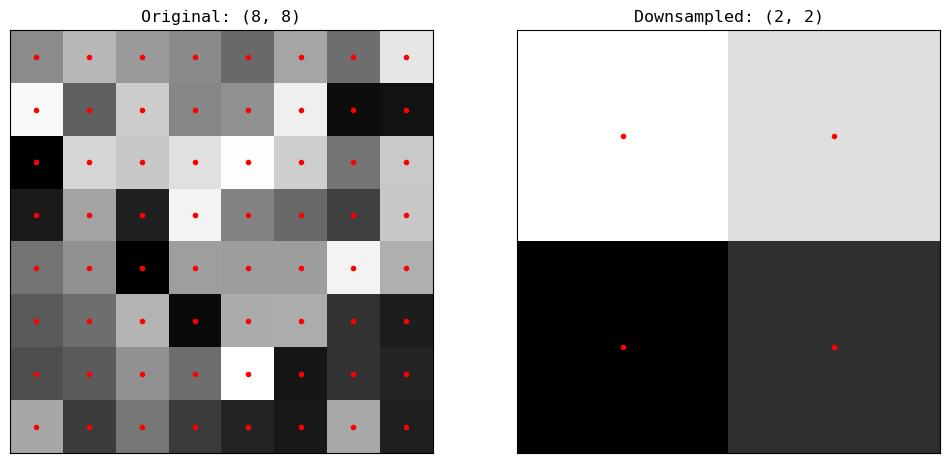

In [129]:
from skimage import transform

np.random.seed(0)

image = np.random.random((8,8))
image_rescaled = transform.downscale_local_mean(image, (4,4))

_, (win_left, win_right) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

win_left.imshow(image, cmap='gray')
win_left.set_xticks([])
win_left.set_yticks([])
centers = np.indices(image.shape).reshape(2, -1).T
win_left.plot(centers[:, 0], centers[:, 1], '.r')
win_left.set_title(f'Original: {image.shape}')

win_right.imshow(image_rescaled, cmap='gray')
win_right.set_xticks([])
win_right.set_yticks([])
centers = np.indices(image_rescaled.shape).reshape(2, -1).T
win_right.plot(centers[:, 0], centers[:, 1], '.r');
win_right.set_title(f'Downsampled: {image_rescaled.shape}')


### Spacing:

- distance between pixels in each dimension
- encoded as a tuple
- Spacing reported by microscope 
- can be accepted as a parameter by some skimage functions and adjust contributions to filter, and help decide when to apply operations planewise
- Above we downsampled by a factor of 4 in the row and column to make data smaller, and also normalise it to 1.0 in the row and column dimensions 

In [130]:
# The microscope reports the following spacing:
original_spacing = np.array([0.2900000, 0.0650000, 0.0650000])
print(f'* Microscope original spacing: {original_spacing}')

# We downsampled each slice 4x to make the data smaller
rescaled_spacing = original_spacing * [1, 4, 4]
print(f'* Microscope after rescaling images: {rescaled_spacing}')

# Normalize the spacing so that pixels are a distance of 1 apart
spacing = rescaled_spacing / rescaled_spacing[2]
print(f'* Microscope normalized spacing: {spacing}')


* Microscope original spacing: [0.29  0.065 0.065]
* Microscope after rescaling images: [0.29 0.26 0.26]
* Microscope normalized spacing: [1.11538462 1.         1.        ]


## Filters

- Median filter (not 3d, apply planewise) removes noise. 
- Effective for salt and pepper noise. 
- It also preserves edges.
- Helpful segmentation because original shape for ROI is preserved

### skimage.util

Example useful functions
- util.img_as_*  - are convenience functions for datatype conversion
- util.invert - to invert any image, accounting for its datatype
- util.random_noise - apply x amount of noise to images. set seed, get pseudo-random noise fpr testing
- util.view_as_* - allows for overlapping views into same memory array, minimising memory impact
- util.apply_parallel - Uses Dask to apply a function across subsections of image
- util.pad and util crop
 

In [131]:
from skimage import util

In [132]:
cells_rescaled_ubyte = util.img_as_ubyte(cells)
cells_median = np.empty_like(cells_rescaled_ubyte)

for plane, image in enumerate(cells_rescaled_ubyte):
    cells_median[plane] = filters.median(image)

cells_median = util.img_as_float(cells_median);

sc.slice_explorer(cells_median)

interactive(children=(IntSlider(value=30, description='plane', max=59), Output()), _dom_classes=('widget-inter…

<function supplementary_code.slice_explorer.<locals>.display_slice(plane=30.0)>

In [133]:
cells_denoised = cells_median

## Thresholding

- Used to create binary images
- Threshold value determines intensity value separating foreground pixels from background pixels
- Foreground pixels are brighter than the threshold value
- Background pixels are darker 
- Thresholding is a form of image segmentation
- Different thresholding algorithms produce different results

In [134]:
threshold_li = filters.threshold_li(cells_denoised)
cells_binary_li = cells_denoised >= threshold_li

threshold_otsu = filters.threshold_otsu(cells_denoised)
cells_binary_otsu = cells_denoised >= threshold_otsu

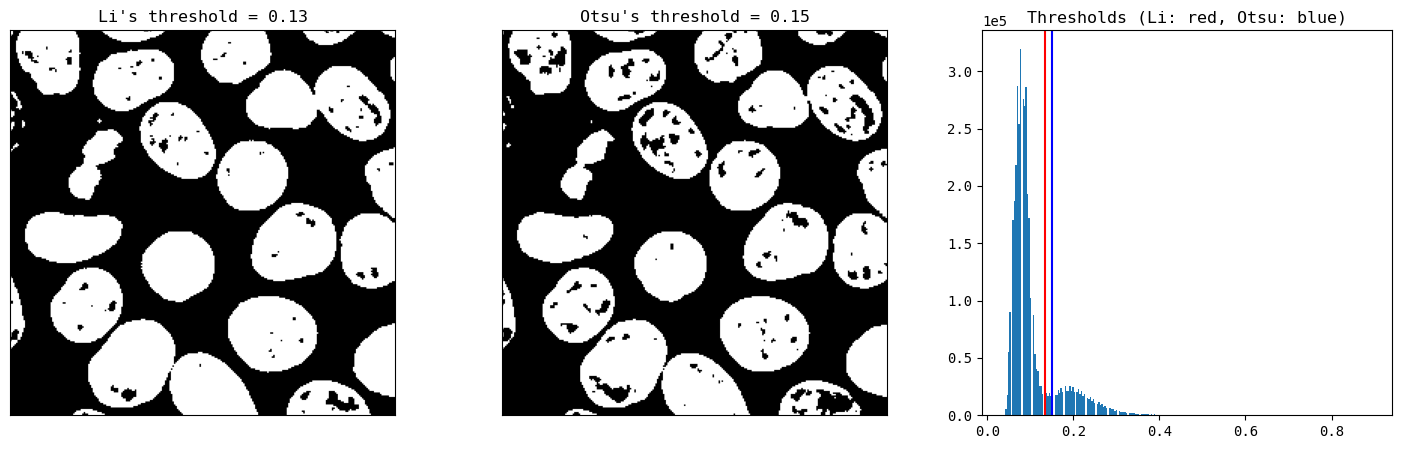

In [135]:
_, (win_left, win_center, win_right) = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

sc.show_plane(win_left,
              cells_binary_li[32],
              title='Li\'s threshold = {:0.2}'.format(threshold_li))
sc.show_plane(win_center,
              cells_binary_otsu[32],
              title='Otsu\'s threshold = {:0.2}'.format(threshold_otsu))

sc.plot_hist(win_right, cells_denoised, 'Thresholds (Li: red, Otsu: blue)')
win_right.axvline(threshold_li, c='r')
win_right.axvline(threshold_otsu, c='b')



In [136]:
# Keeping threshold binary li 
cells_binary = cells_binary_li
sc.slice_explorer(cells_binary)

interactive(children=(IntSlider(value=30, description='plane', max=59), Output()), _dom_classes=('widget-inter…

<function supplementary_code.slice_explorer.<locals>.display_slice(plane=30.0)>

## skimage.morphology: binary and grayscale morphology

- Morphological image processing is a collection of non-linear operations related to the shape / morphology of features in an image. Eg. boundaries, skeletons 
- In each technique, an image is probed with a small shape or template called a structuring element which defines the region of interest or neighborhood around a pixel
- Structuring elements are shapes which define areas over which an operation is applied
- The response to the filter indicates how well the neighborhood corresponds to the structuring element's shape

In [137]:
from skimage import morphology

Functions operating on connected components can remove small undesired elements while preserving larger shapes

- skimage.morphology.remove_small_holes fills holes
- skimage.morphology.remove_small_objects removes bright regions
- Both functions accept a min_size (in pixels) of accepted holes or objects
- min_size can be approximated by a cube

In [138]:
width = 20
cells_remove_holes = morphology.remove_small_holes(cells_binary, width **3)

sc.slice_explorer(cells_remove_holes)

interactive(children=(IntSlider(value=30, description='plane', max=59), Output()), _dom_classes=('widget-inter…

<function supplementary_code.slice_explorer.<locals>.display_slice(plane=30.0)>

In [139]:
width = 20
cells_remove_objects = morphology.remove_small_objects(cells_binary, width **3)

sc.slice_explorer(cells_remove_objects)

interactive(children=(IntSlider(value=30, description='plane', max=59), Output()), _dom_classes=('widget-inter…

<function supplementary_code.slice_explorer.<locals>.display_slice(plane=30.0)>

## skimage.measure - measure image or region properties

- measure.label: label an image eg. identify discreete regions in the image using unique integers
- measure.regionprops: in  a labeled image, as returned by [label], find various properties of the labeled regions

Finding paths from a 2D image or isosurfaces from a 3D image:
- measure.find_contours
- measure.marching_cubes_lewiner
- measure.marching_cubes_classic
- measure.mesh_surface_area ------> surface area of 3D mesh from marching cubes
- measure.compare_* ------> Quantify the difference between the two whole images, often used in denoising or restoration


**RANDom sample consensus fitting (RANSAC)**
- fitting a model to data
- fitting shapes or fit transforms

- measure.ransac
- measure.CircleModel
- measure.EllipseModel
- measure.LineModelND

Image segmentation partitions images into regions of interest. Integer labels are assigned to each region to distinguish regions of interest.

- Connected components of the binary image are assigned the same label via skimage.measure.label

In [140]:
from skimage import measure # skimage measure submodule

In [141]:
cells_label = measure.label(cells_remove_objects)

interactive(children=(IntSlider(value=30, description='plane', max=59), Output()), _dom_classes=('widget-inter…

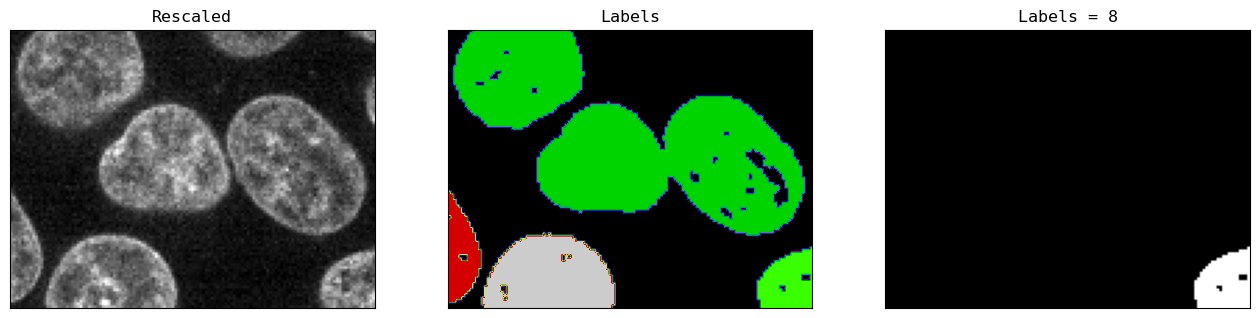

In [142]:
sc.slice_explorer(cells_label, cmap='nipy_spectral');

_, (win_left, win_center, win_right) = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

sc.show_plane(win_left, cells_rescaled[32, :100, 125:], title='Rescaled')
sc.show_plane(win_center, cells_label[32, :100, 125:], cmap='nipy_spectral', title='Labels')
sc.show_plane(win_right, cells_label[32, :100, 125:] == 8, title='Labels = 8')


Watershed segmentation can distinguish touching objects. 
- Markers are placed at local minima and expanded outward until their is a collision with markers from another region. The inverse intensity imagae transforms the bright cell regions into basins which should be filled

- in declumping, markers are generated from the distance function
- points furthest from an edge have the highest intensity and should be identified as markers using [skimage.feature.peak_local_max]. Regions with pinch points should be assigned multiple markers

In [143]:
cells_distance = ndimage.distance_transform_edt(cells_remove_objects)

In [144]:
sc.slice_explorer(cells_distance, cmap='viridis');

interactive(children=(IntSlider(value=30, description='plane', max=59), Output()), _dom_classes=('widget-inter…

### skimage.feature: extract features from an image


    Edge detection: feature.canny
    Corner detection:
        feature.corner_kitchen_rosenfeld
        feature.corner_harris
        feature.corner_shi_tomasi
        feature.corner_foerstner
        feature.subpix
        feature.corner_moravec
        feature.corner_fast
        feature.corner_orientations
    Blob detection
        feature.blob_dog
        feature.blob_doh
        feature.blob_log
    Texture
        feature.greycomatrix
        feature.greycoprops
        feature.local_binary_pattern
        feature.multiblock_lbp
    Peak finding: feature.peak_local_max
    Object detction
        feature.hog
        feature.match_template
    Stereoscopic depth estimation: feature.daisy
    Feature matching
        feature.ORB
        feature.BRIEF
        feature.CENSURE
        feature.match_descriptors
        feature.plot_matches


In [145]:
from skimage import feature 

### skimage.segmentation - identify ROI

- 2 general categories for segmentation:

**1. Supervised**- must provide guidance or initial conditions 

- segmentation.random_walker
- segmentation.active_contour
- segmentation.watershed
- segmentation.flood_fill
- segmentation.flood

**1. Unupervised**- no human input 
- segmentation.slic
- segmentation.felzenszwalb
- segmentation.chan_vese 

- also sup/unsupervised thresholding algo in filters


Feature extraction reduces data required to desceribe an image or objects by measuring informative features. These include features such as area, volume, bounding boxes or intensity statistics.

- before measuring objects, it helps to clear objects from the image border
- measurements should only be collected for objects entirely contained in the iamge

In [146]:
from skimage import segmentation

*Modified from original tutorial* - using this as [reference]('https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_watershed.html') 

In [147]:
coordinates = feature.peak_local_max(
    cells_distance,
    footprint=np.ones((15, 15, 15), dtype=bool),
    labels=measure.label(cells_remove_objects)
)

In [148]:
mask = np.zeros_like(cells_distance, dtype=bool)
mask[tuple(coordinates.T)] = True

In [149]:
markers, _ = ndimage.label(mask)

In [150]:
labels = segmentation.watershed(cells_rescaled, markers, mask = cells_remove_holes)
sc.slice_explorer(labels, cmap='nipy_spectral')

interactive(children=(IntSlider(value=30, description='plane', max=59), Output()), _dom_classes=('widget-inter…

<function supplementary_code.slice_explorer.<locals>.display_slice(plane=30.0)>

Plotting the markers on the distance image reveals the reason for oversegmentation. Cells with multiple markers will be assigned multiple labels, and oversegmented. It can be observed that cells with a uniformly increasing distance map are assigned a single marker near their center. Cells with uneven distance maps are assigned multiple markers, indicating the presence of multiple local maxima.

- Improve feature selection by blurring, using a larger footprint
- in `peak_local_max`, etc.


In [151]:
# smooth_distance = filters.gaussian(cells_distance[10:, 193:253, 74], sigma=5)
# sc.show_plane(win_right, smooth_distance)
# features = feature.peak_local_max(
#     smooth_distance
# )

Remove cells at border

In [152]:
labels_remove_border = segmentation.clear_border(labels)

In [153]:
labels_remove_border = morphology.remove_small_objects(labels_remove_border, min_size=200)

In [154]:
print(f'Interior labels: {np.unique(labels_remove_border)}')

Interior labels: [ 0 11 16 23 26 30 32 33 62 65]


In [155]:
sc.slice_explorer(labels_remove_border, cmap='nipy_spectral');


interactive(children=(IntSlider(value=30, description='plane', max=59), Output()), _dom_classes=('widget-inter…

After clearing the border, the object labels are no longer sequentially increasing. The labels can be renumbered such that there are no jumps in the list of image labels:

In [156]:
cells_relabeled, _, _ = segmentation.relabel_sequential(labels_remove_border)
print(f'Relabeled labels: {np.unique(cells_relabeled)}')

Relabeled labels: [0 1 2 3 4 5 6 7 8 9]


- skimage.measure.regionprops auto measure many labeled image features.
- Optionally, an [intensity_image] can be supplied and intensity features are extracted per object
- not all properties supported for 3D:


In [157]:
properties = measure.regionprops(cells_relabeled, intensity_image=cells)
props_first_region = properties[0]

supported = [''] 
unsupported = ['']

for prop in props_first_region:
    try:
        props_first_region[prop]
        supported.append(prop)
    except NotImplementedError:
        unsupported.append(prop)

print('Supported properties:')
print('\n\t'.join(supported))
print()
print('Unsupported properties:')
print('\n\t'.join(unsupported))


Supported properties:

	area
	area_bbox
	area_convex
	area_filled
	axis_major_length
	axis_minor_length
	bbox
	centroid
	centroid_local
	centroid_weighted
	centroid_weighted_local
	coords
	equivalent_diameter_area
	euler_number
	extent
	feret_diameter_max
	image
	image_convex
	image_filled
	image_intensity
	inertia_tensor
	inertia_tensor_eigvals
	intensity_max
	intensity_mean
	intensity_min
	label
	moments
	moments_central
	moments_normalized
	moments_weighted
	moments_weighted_central
	moments_weighted_normalized
	slice
	solidity

Unsupported properties:

	eccentricity
	moments_hu
	moments_weighted_hu
	orientation
	perimeter
	perimeter_crofton


skimage.measure.regionprops ignores the label 0, which represents the background.


In [158]:
print(f'Measured regions: {[prop.label for prop in properties]}')

Measured regions: [1, 2, 3, 4, 5, 6, 7, 8, 9]


In [159]:
cells_volumes = [prop.area for prop in properties]
print(f'Total pixels: {cells_volumes}')

Total pixels: [39810.0, 36901.0, 47989.0, 46670.0, 36875.0, 41831.0, 39602.0, 39511.0, 47349.0]


Collected measurements can be further reduced by computing per-image statistics such as total, minimum, maximum, mean, and standard deviation.

In [160]:
print('Volume statistics\n')
print(f' * Total: {np.sum(cells_volumes)}')
print(f' * Min: {np.min(cells_volumes)}')
print(f' * Max: {np.max(cells_volumes)}')
print(' * Mean: {:0.2f}'.format(np.mean(cells_volumes)))
print(' * Standard deviation: {:0.2f}'.format(np.std(cells_volumes)))

Volume statistics

 * Total: 376538.0
 * Min: 36875.0
 * Max: 47989.0
 * Mean: 41837.56
 * Standard deviation: 4151.13


### Visualisation

- Use the perimeters of a region to generate their plots. 
- perimeter measurements are not computed for 3D objects. 
- Using the fact that 3D extension of perimeter is **surface area,** we can measure the surface of an object by generating a surface mesh with [skimage.measure.marching_cubes] and computing the surface area of the mesh with [skimage.measure.mesh_surface_area]. The function[ plot_3d_surface] has it 


Surface area

 * Total pixels: 7192.86
 * Actual: 7797.23


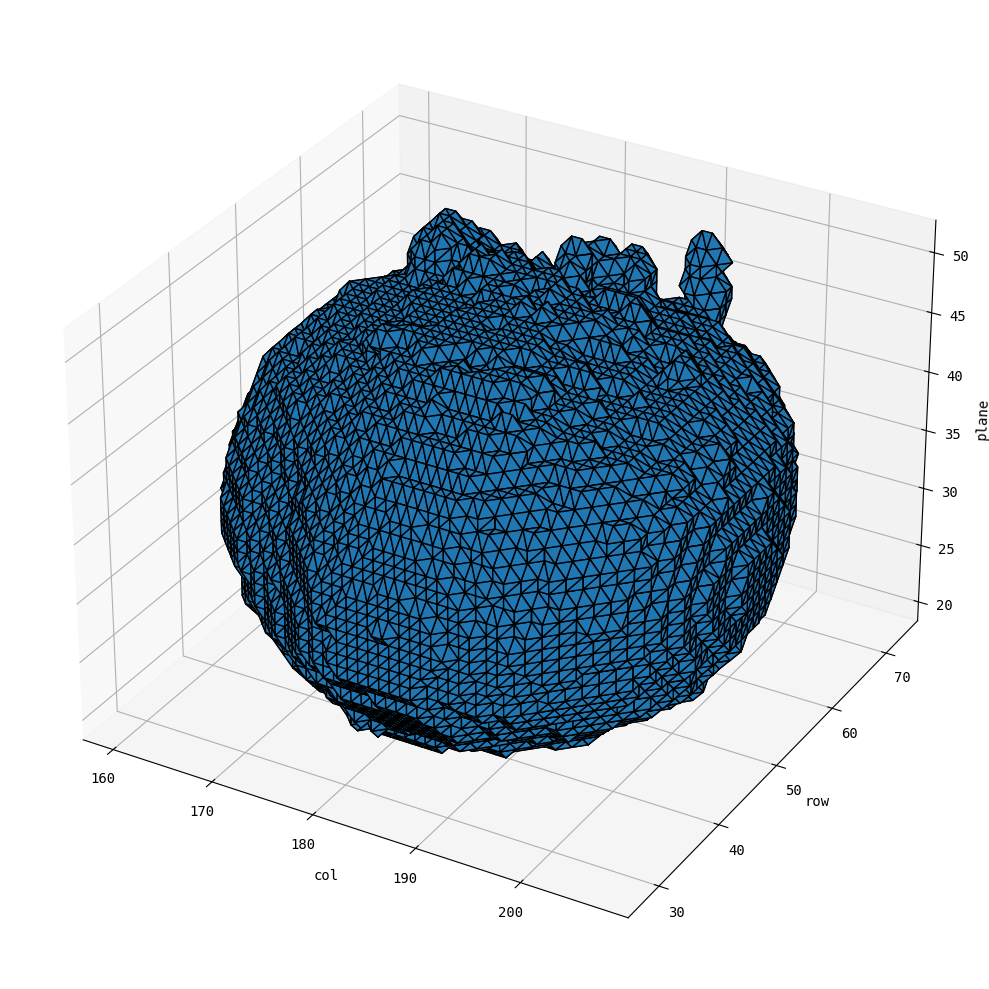

In [161]:
sc.plot_3d_surface(data=cells,
                   labels=cells_relabeled,
                   region=6,
                   spacing=spacing)